# Homework 2

In [298]:
# Import libraries

%matplotlib inline
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [164]:
URL_PATH = 'https://www.topuniversities.com'
RANKING_DATA_URL = URL_PATH + '/sites/default/files/qs-rankings-data/357051.txt'
response = requests.get(RANKING_DATA_URL)

raw_data = json_normalize(response.json(), 'data')

In [165]:
# Get Top 200 universities
max_rank = 200
top200 = raw_data[: max_rank]

#Add URL to dataframe
top200.head()

,cc,core_id,country,guide,logo,nid,rank_display,region,score,stars,title,url
0,US,410,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294850,1,North America,100,6,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,US,573,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",297282,2,North America,98.7,5,Stanford University,/universities/stanford-university
2,US,253,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294270,3,North America,98.4,5,Harvard University,/universities/harvard-university
3,US,94,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294562,4,North America,97.7,5,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,GB,95,United Kingdom,"<a href=""/where-to-study/europe/united-kingdom...","<img src=""https://www.topuniversities.com/site...",294561,5,Europe,95.6,5,University of Cambridge,/universities/university-cambridge


Comment:
indian-institute-technology-delhi-iitd has no international faculty staff so put zero

In [166]:
def str_to_numeric(str):
    return int(str.replace(',',''))

def find_numbers(soup, attribute):
    try:
        div = soup.find('div', class_=attribute).find('div', class_="number")
        if div:
            return str_to_numeric(div.text)
        else:
            return 0
    except AttributeError:
        return 0
        

fac_staff = []
inter_staff = []
total_stud = []
inter_stud = []

for i, row in top200.iterrows():
    
    url = row.url
    
    response = requests.get(URL_PATH + url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Get number of total academic faculty staff
    total_faculty_staff = find_numbers(soup, 'total faculty')

    # Get number of international academic staff
    international_faculty_staff = find_numbers(soup, 'inter faculty')

    # Get number of total students
    total_students = find_numbers(soup, 'total student')

    # Get number of international students
    international_students = find_numbers(soup, 'inter')
    
    fac_staff.append(total_faculty_staff)
    inter_staff.append(international_faculty_staff)
    total_stud.append(total_students)
    inter_stud.append(international_students)
    
    
total_faculty_staff_pd = pd.DataFrame(fac_staff, columns=['total_faculty_staff'])
international_faculty_staff_pd = pd.DataFrame(inter_staff, columns=['international_faculty_staff'])
total_students_pd = pd.DataFrame(total_stud, columns=['total_students'])
international_students_pd = pd.DataFrame(inter_stud, columns=['international_students'])

top200_completed = pd.concat([top200, total_faculty_staff_pd, international_faculty_staff_pd, total_students_pd, international_students_pd], axis=1)

/universities/massachusetts-institute-technology-mit
/universities/stanford-university
/universities/harvard-university
/universities/california-institute-technology-caltech
/universities/university-cambridge
/universities/university-oxford
/universities/ucl-university-college-london
/universities/imperial-college-london
/universities/university-chicago
/universities/eth-zurich-swiss-federal-institute-technology
/universities/nanyang-technological-university-singapore-ntu
/universities/ecole-polytechnique-f%C3%A9d%C3%A9rale-de-lausanne-epfl
/universities/princeton-university
/universities/cornell-university
/universities/national-university-singapore-nus
/universities/yale-university
/universities/johns-hopkins-university
/universities/columbia-university
/universities/university-pennsylvania
/universities/australian-national-university
/universities/duke-university
/universities/university-michigan
/universities/kings-college-london
/universities/university-edinburgh
/universities/tsi

In [183]:
top200_completed = top200_completed[['title', 'rank_display', 'country', 'region', 'total_faculty_staff', 'international_faculty_staff', 'total_students', 'international_students']]

Calculate ratios

In [186]:
top200_completed['ratio staff/student'] = (top200_completed.total_faculty_staff / top200_completed.total_students)
top200_completed['ratio international student'] = (top200_completed.international_students / top200_completed.total_students)

In [187]:
top200_completed

,title,rank_display,country,region,total_faculty_staff,international_faculty_staff,total_students,international_students,ratio staff/student,ratio international student
0,Massachusetts Institute of Technology (MIT),1,United States,North America,2982,1679,11067,1679,0.269450,0.151712
1,Stanford University,2,United States,North America,4285,2042,15878,2042,0.269870,0.128606
2,Harvard University,3,United States,North America,4350,1311,22429,1311,0.193945,0.058451
3,California Institute of Technology (Caltech),4,United States,North America,953,350,2255,350,0.422616,0.155211
4,University of Cambridge,5,United Kingdom,Europe,5490,2278,18770,2278,0.292488,0.121364
5,University of Oxford,6,United Kingdom,Europe,6750,2964,19720,2964,0.342292,0.150304
6,UCL (University College London),7,United Kingdom,Europe,6345,2554,31080,2554,0.204151,0.082175
7,Imperial College London,8,United Kingdom,Europe,3930,2071,16090,2071,0.244251,0.128713
8,University of Chicago,9,United States,North America,2449,635,13557,635,0.180645,0.046839
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,2477,1886,19815,1886,0.125006,0.095180


In [404]:
#Sorting by first ratio - TOP 10
top10_1 = top200_completed.sort_values(['ratio staff/student'], ascending = 0).head(10)
top10_1

,title,rank_display,country,region,total_faculty_staff,international_faculty_staff,total_students,international_students,ratio staff/student,ratio international student
3,California Institute of Technology (Caltech),4,United States,North America,953,350,2255,350,0.422616,0.155211
15,Yale University,16,United States,North America,4940,1708,12402,1708,0.398323,0.137720
5,University of Oxford,6,United Kingdom,Europe,6750,2964,19720,2964,0.342292,0.150304
4,University of Cambridge,5,United Kingdom,Europe,5490,2278,18770,2278,0.292488,0.121364
16,Johns Hopkins University,17,United States,North America,4462,1061,16146,1061,0.276353,0.065713
1,Stanford University,2,United States,North America,4285,2042,15878,2042,0.269870,0.128606
0,Massachusetts Institute of Technology (MIT),1,United States,North America,2982,1679,11067,1679,0.269450,0.151712
185,University of Rochester,186,United States,North America,2569,488,9636,488,0.266604,0.050643
18,University of Pennsylvania,19,United States,North America,5499,1383,20639,1383,0.266437,0.067009
17,Columbia University,18,United States,North America,6189,913,25045,913,0.247115,0.036454


In [402]:
#Sorting by second ratio
top10_2 = top200_completed.sort_values(['ratio international student'], ascending = 0).head(10)

In [411]:
def plot_data_bar(data, ax, title='', ylabel=''):
    ax.set_xlabel(data.index)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.set_title(title, fontsize=14, fontweight='bold')
    sns.barplot(x=title, y=data.index, data=data, ax=ax, palette="Greens_r")
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    
def plot_data_bar_here(data, ax, title='', ylabel=''):
    ax.set_xlabel(data.title)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.set_title('Top 10 - ' + title, fontsize=14, fontweight='bold')
    sns.barplot(x=title, y=data.title, data=data, ax=ax, palette="Greens_r")
    locs, labels = plt.xticks(rotation=90)
    plt.setp(labels, rotation=90)

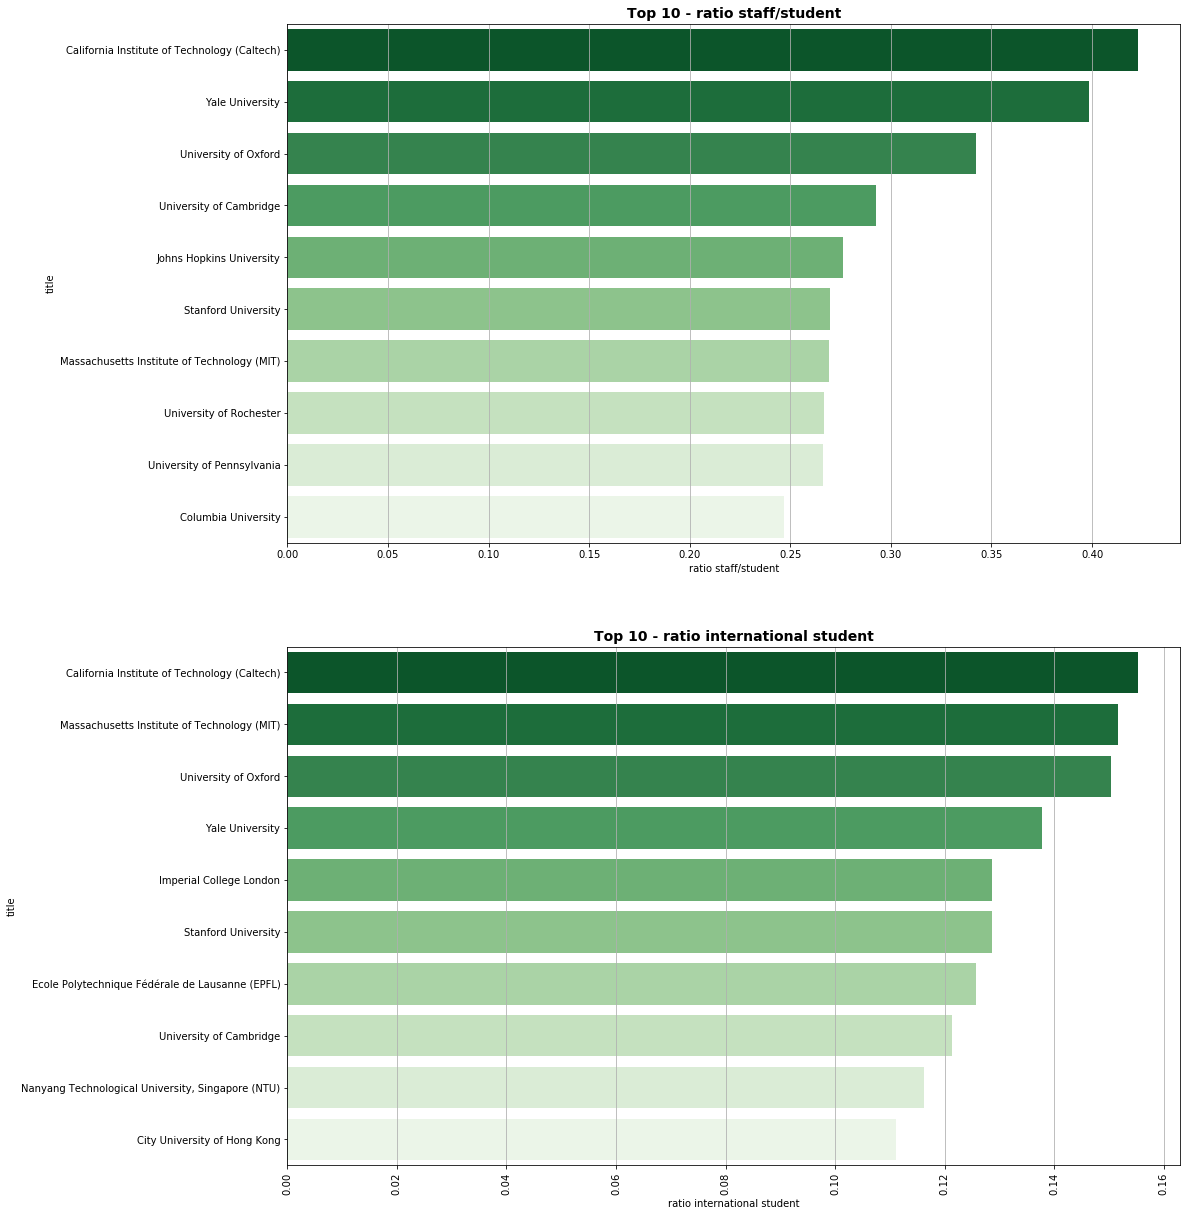

In [412]:
figure, axes = plt.subplots(2, 1, figsize=(16, 21))

plot_data_bar_here(top10_1, axes[0], 'ratio staff/student')
plot_data_bar_here(top10_2, axes[1], 'ratio international student')

In [413]:
# Group by country - mean
data_1 = top200_completed.groupby(['country'])[['ratio staff/student']].mean()
data_sorted_1 = data_1.sort_values('ratio staff/student', ascending=0)

# Group by country - mean
data_2 = top200_completed.groupby(['country'])[['ratio international student']].mean()
data_sorted_2 = data_2.sort_values('ratio international student', ascending=0)


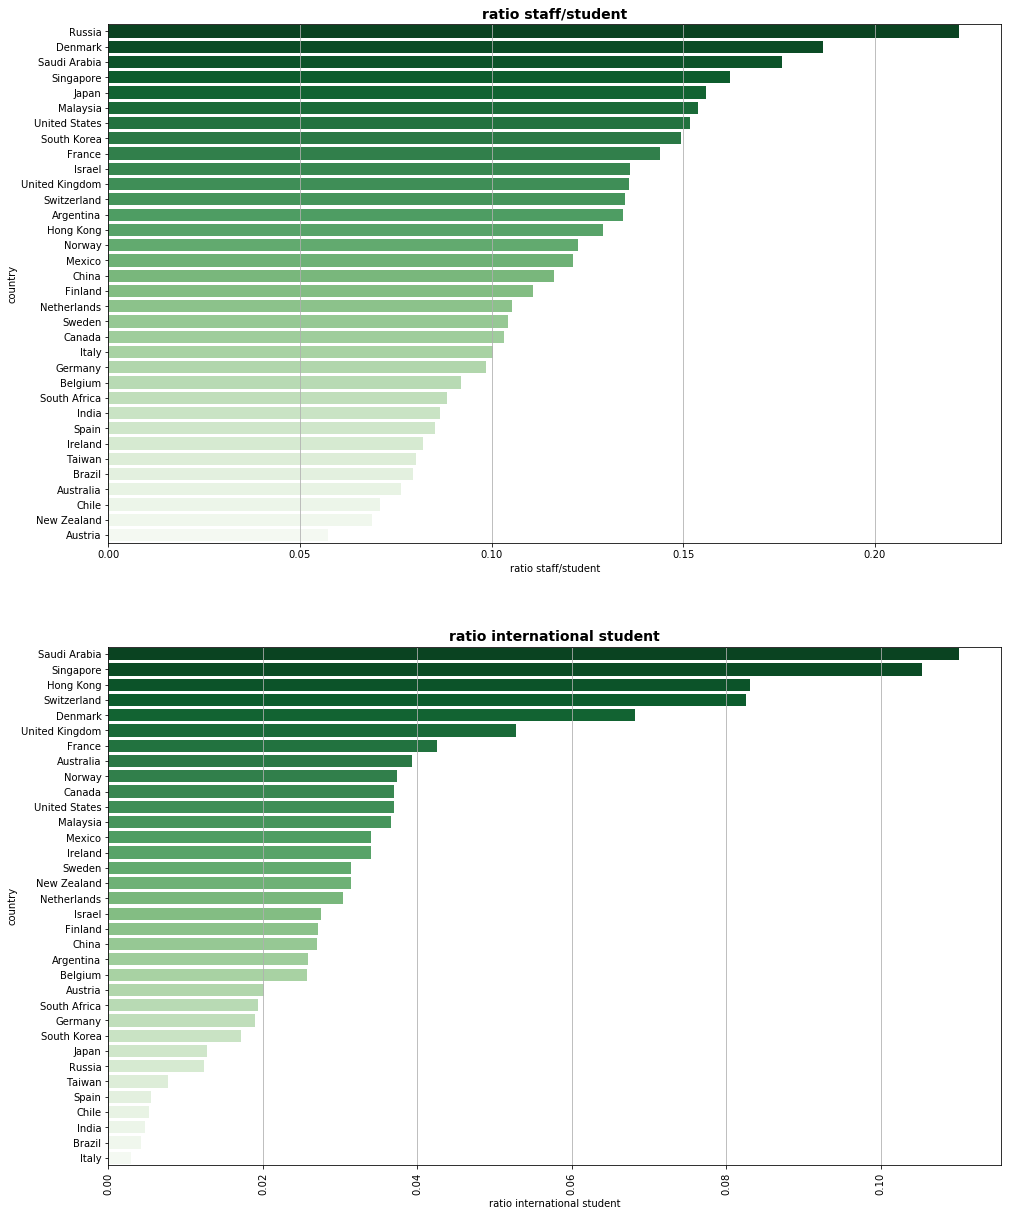

In [414]:
figure, axes = plt.subplots(2, 1, figsize=(16, 21))

plot_data_bar(data_sorted_1, axes[0], 'ratio staff/student')
plot_data_bar(data_sorted_2, axes[1], 'ratio international student')

In [415]:
# Group by region - mean
data_1 = top200_completed.groupby(['region'])[['ratio staff/student']].mean()
data_sorted_1 = data_1.sort_values('ratio staff/student', ascending=0)

# Group by region - mean
data_2 = top200_completed.groupby(['region'])[['ratio international student']].mean()
data_sorted_2 = data_2.sort_values('ratio international student', ascending=0)

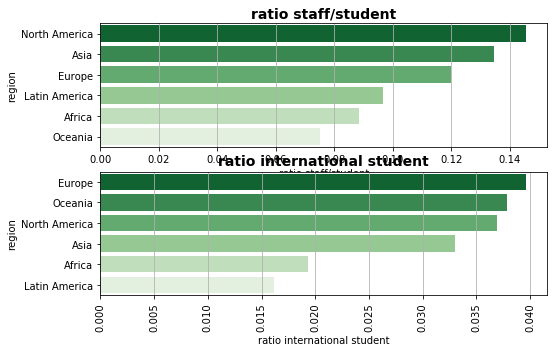

In [416]:
figure, axes = plt.subplots(2, 1, figsize=(8, 5))

plot_data_bar(data_sorted_1, axes[0], 'ratio staff/student')
plot_data_bar(data_sorted_2, axes[1], 'ratio international student')